In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import copy
import scipy.io
import sklearn
import sklearn.datasets

from nn_building_blocks import *

%matplotlib inline

### Dataset

In [2]:
data = scipy.io.loadmat("datasets/data.mat")
train_x = data["X"].T
train_y = data["y"].T
test_x = data["Xval"].T
test_y = data["yval"].T

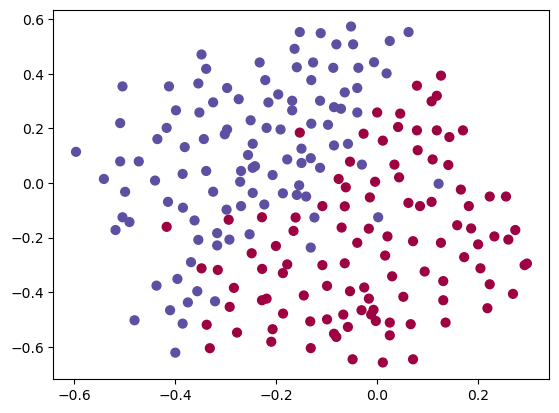

In [3]:
plt.scatter(train_x[0, :], train_x[1, :], c=train_y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [4]:
print(f"xtr: {train_x.shape}, xtt: {test_x.shape}, ytr: {train_y.shape}, ytt: {test_y.shape}")

xtr: (2, 211), xtt: (2, 200), ytr: (1, 211), ytt: (1, 200)


### Model

In [185]:
def initialize_parameters1(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) 

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [186]:
def model(X, Y, learning_rate=0.3, num_iterations=30000, print_cost=True, lambd=0, keep_prob=1):
    assert (lambd ==0 or keep_prob==1)
    
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dim = [X.shape[0], 20, 3, 1]

    parameters = initialize_parameters1(layers_dim)

    for i in range(num_iterations):
        if keep_prob == 1:
            al, cache = L_model_forward(X, parameters)
        elif keep_prob < 1:
            al, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
    
        if lambd == 0:
            cost = compute_cost(al, Y)
        else:
            cost = compute_cost_with_regularization(al, Y, parameters, lambd)
    
        if lambd == 0 and keep_prob == 1:
            grads = L_model_backward_direct(al, Y, cache)
        elif lambd != 0:
            grads = L_model_backward_direct_reg(X, Y, cache, lambd, al)

        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob, al)
    
        parameters = update_parameters(parameters, grads, learning_rate)
    
        if print_cost and (i%10000 == 0 or i == num_iterations-1):
            print(f"Iteration: {i}, Cost: {cost}")
        if i % 1000 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

### Not Regularized

Iteration: 0, Cost: 0.6557412523481002
Iteration: 10000, Cost: 0.16329987528400203
Iteration: 20000, Cost: 0.13851642441374346
Iteration: 29999, Cost: 0.12509131298616602


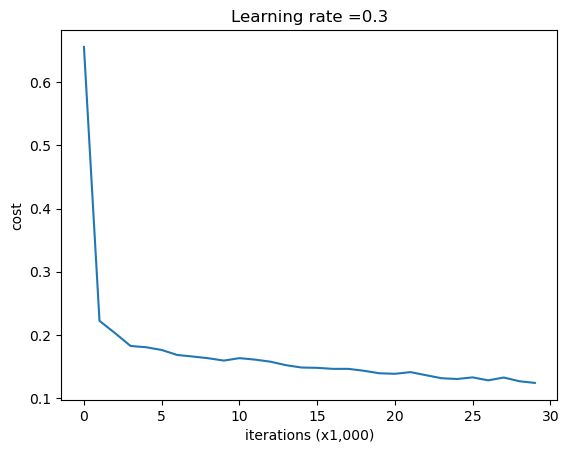

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.9149999999999998


In [187]:
parameters = model(train_x, train_y)
print ("On the training set:")
predictions_train = predict(train_x, train_y, parameters)
print ("On the test set:")
predictions_test = predict(test_x, test_y, parameters)

In [188]:
def compute_cost_with_regularization(al, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 2
    cross_entropy_cost = compute_cost(al, Y)
    L2_regularization_cost = 0

    for l in range(1, L+1):
        L2_regularization_cost += np.sum(np.square(parameters["W"+str(l)]))

    L2_regularization_cost = (1./m)*(lambd/2)*L2_regularization_cost
    
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

In [189]:
def linear_backward_reg(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T) + ((lambd/m)*W)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [190]:
def linear_activation_backward_reg(dA, cache, lambd=0):
    linear_cache, activation_cache = cache

    dZ = relu_backwards(dA, activation_cache)
    # dZ = np.multiply(dA, np.int64(linear_cache[0] > 0))
    dA_prev, dW, db = linear_backward_reg(dZ, linear_cache, lambd)
    # print(activation_cache.shape)
    return dA_prev, dW, db

In [192]:
def L_model_backward_direct_reg(X, Y, caches, lambd, al):
    grads = {}
    L = len(caches)
    m = X.shape[1]
    # Y = Y.reshape(AL.shape)

    current_cacheL = caches[-1]
    linear_cache, activation_cache = current_cacheL
    # print(activation_cache.shape)
    
    dZL = (al-Y)

    A_minus_l, WL, bL = linear_cache
    

    dW_temp = 1/m * np.dot(dZL, A_minus_l.T) + ((lambd/m)*WL)
    db_temp = 1/m * np.sum(dZL, axis=1, keepdims=True)
    dA_prev_temp = np.dot(WL.T, dZL)
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp 
    grads["db" + str(L)] = db_temp
    
    
    for l in reversed(range(L-1)):
        dA_prev = dA_prev_temp
        (Al_minus_1, Wl, Bl), dZl = caches[l] 
        # print(Al.shape)
        dA_prev_temp, dW_plus_1, db_plus_1 = linear_activation_backward_reg(dA_prev, ((Al_minus_1, Wl, Bl), dZl), lambd)

        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_plus_1
        grads["db" + str(l+1)] = db_plus_1
        
    return grads

In [193]:
# t_X, t_Y, cache = backward_propagation_with_regularization_test_case()

# grads = L_model_backward_direct_reg(t_X, t_Y, cache, lambd = 0.7)
# print ("dW1 = \n"+ str(grads["dW1"]))
# print ("dW2 = \n"+ str(grads["dW2"]))
# print ("dW3 = \n"+ str(grads["dW3"]))
# backward_propagation_with_regularization_test(L_model_backward_direct_reg)

Iteration: 0, Cost: 0.6974484493131264
Iteration: 10000, Cost: 0.2684918873282239
Iteration: 20000, Cost: 0.26809163371273004
Iteration: 29999, Cost: 0.2678617428709586


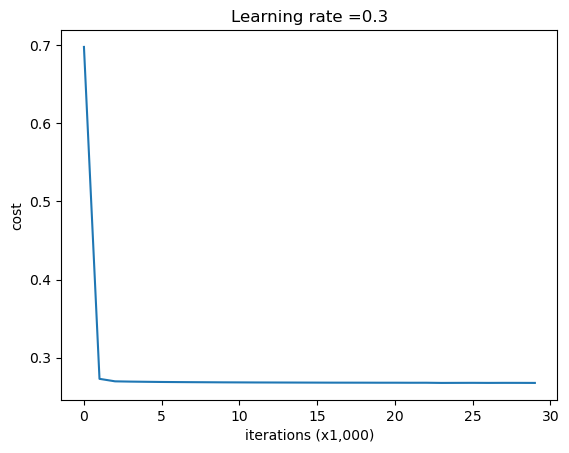

On the training set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.9299999999999998


In [194]:
parameters = model(train_x, train_y, lambd=0.7, num_iterations=30000)
print ("On the training set:")
predictions_train = predict(train_x, train_y, parameters)
print ("On the test set:")
predictions_test = predict(test_x, test_y, parameters)

### Dropout

In [195]:
def linear_activation_forward_dropout(A_prev, W, b, activation, keep_prob=1):

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        # D = np.random.rand(*A.shape)
        # mask = (D < keep_prob).astype(int)
        # A = (A*mask)/keep_prob
        mask = None
    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        D = np.random.rand(*A.shape)
        mask = (D < keep_prob).astype(int)
        A = (A*mask)/keep_prob
    cache = (linear_cache, activation_cache, mask)
    
    return A, cache

In [197]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 1):

    np.random.seed(1)
    L = len(parameters)//2
    caches = []
    A = X

    
    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward_dropout(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu", keep_prob)
        caches.append(cache)

    AL, cache = linear_activation_forward_dropout(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid", keep_prob)
    caches.append(cache)
    
    return AL, caches

In [198]:
# t_X, parameters = forward_propagation_with_dropout_test_case()

# A3, cache = forward_propagation_with_dropout(t_X, parameters, keep_prob=0.7)
# print ("A3 = " + str(A3))

# forward_propagation_with_dropout_test(forward_propagation_with_dropout)

In [199]:
def linear_activation_backward_dropout(dA, cache, activation, keep_prob=1):
    linear_cache, activation_cache, mask = cache

    if activation == "relu":
        dZ = relu_backwards(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        dA_prev = (dA_prev * mask) / keep_prob
    if activation == "sigmoid":
        dZ = sigmoid_backwards(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [204]:
def backward_propagation_with_dropout(X, Y, caches, keep_prob, AL):
    grads = {}
    L = len(caches)
    m = X.shape[1]
    Y = Y.reshape(AL.shape)
    
    dZL = (AL-Y)
    current_cacheL = caches[-1]
    linear_cache, activation_cache, D3 = current_cacheL
    _, _, D2 = caches[-2]
    A_prev_L, WL, bL = linear_cache

    dA_prev_temp = np.dot(WL.T, dZL)
    dW_temp = (1/m) * np.dot(dZL, A_prev_L.T)
    db_temp = (1/m) * np.sum(dZL, axis=1, keepdims=True)
    dA_prev_temp = (dA_prev_temp*D2)/keep_prob
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp 
    grads["db" + str(L)] = db_temp

    
    for l in reversed(range(L-1)):
        dA_prev = dA_prev_temp
        linear_cache, activation_cache, mask  = caches[l]
        _,_,Dl  = caches[l-1]
        # print(activation_cache.shape)
        if l > 0:
            dA_prev_temp, dW_temp, db_temp = linear_activation_backward_dropout(dA_prev, (linear_cache, activation_cache, Dl), "relu", keep_prob)
        else:
            dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev, (linear_cache, activation_cache), "relu")
        
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        
    return grads

In [205]:
# t_X, t_Y, cache = backward_propagation_with_dropout_test_case()

# gradients = backward_propagation_with_dropout(t_X, t_Y, cache, keep_prob=0.8)

# print ("dA1 = \n" + str(gradients["dA1"]))
# print ("dA2 = \n" + str(gradients["dA2"]))

# backward_propagation_with_dropout_test(backward_propagation_with_dropout)

Iteration: 0, Cost: 0.6543912405149825
Iteration: 10000, Cost: 0.06101699099498057
Iteration: 20000, Cost: 0.06058244093866753
Iteration: 29999, Cost: 0.060488180567447744


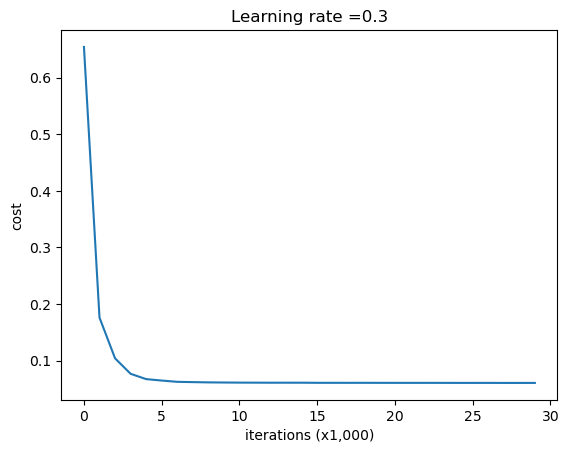

On the training set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.9499999999999998


In [206]:
parameters = model(train_x, train_y, learning_rate=0.3, keep_prob=0.86, num_iterations=30000)
print ("On the training set:")
predictions_train = predict(train_x, train_y, parameters)
print ("On the test set:")
predictions_test = predict(test_x, test_y, parameters)